https://lopezyse.medium.com/computer-vision-image-classification-using-python-913cf7156812

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from torch import nn
import torch
from pytorch_lightning import LightningModule
from torch import nn
from torchinfo import summary
from torchvision import models

import os
import numpy as np
from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

### Data analysis

In [2]:
SCREEN_WIDTH = 1920
SCREEN_HEIGHT = 1080
GRID_COLS = 5
GRID_ROWS = 5
print(f"cell size = {SCREEN_WIDTH/GRID_COLS}x{SCREEN_HEIGHT/GRID_ROWS}")

cell size = 384.0x216.0


In [3]:
# load database
df = pd.read_csv('../data_collection_phase/data/only_face.csv')
df.head()


,File Path Face Image,x,y
0,face_image_1.png,1143,912
1,face_image_2.png,1572,1063
2,face_image_3.png,499,51
3,face_image_4.png,1058,941
4,face_image_5.png,1413,819


1143 912


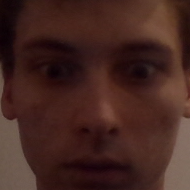

In [4]:
# show first image in df
img_path = df.iloc[0]['File Path Face Image'] # => face_image_1.png
full_path = os.path.join('../data_collection_phase/data/only_face', img_path)
img = Image.open(full_path)
# print point I was looking
print(df.iloc[0]['x'], df.iloc[0]['y'])
img

### Make it classification of cell in screen

In [5]:
# screen is 1920x1080
# we will divide it into 5x5 grid
# so each cell will be 384x216
# so cell 0 will be from (0,0) to (384,216), and so on
# cell 0 top left corner, cell 1 next to it, and so on
df_class = df.copy()
df_class['cell'] = (df['x'] // (SCREEN_WIDTH/GRID_COLS)) + (df['y'] // (SCREEN_HEIGHT/GRID_ROWS)) * GRID_COLS
df_class['cell'] = df_class['cell'].astype(int)
df_class.head()

,File Path Face Image,x,y,cell
0,face_image_1.png,1143,912,22
1,face_image_2.png,1572,1063,24
2,face_image_3.png,499,51,1
3,face_image_4.png,1058,941,22
4,face_image_5.png,1413,819,18


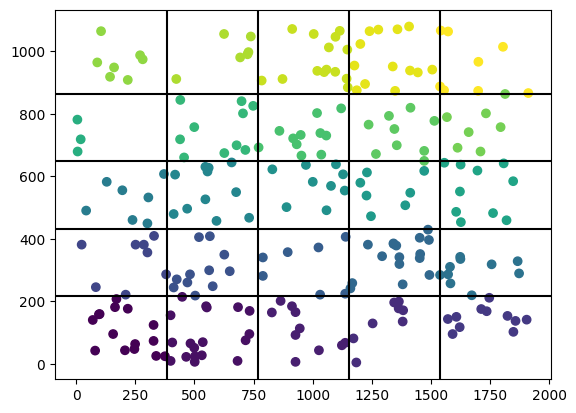

In [6]:
# plot points x,y on graph and color them based on cell
plt.scatter(df_class['x'], df_class['y'], c=df_class['cell'])
# add grid lines
for i in range(1, GRID_COLS):
    plt.axvline(i * (SCREEN_WIDTH/GRID_COLS), color='k')
for i in range(1, GRID_ROWS):
    plt.axhline(i * (SCREEN_HEIGHT/GRID_ROWS), color='k')
plt.show()

### Create image of both eyes toghether

In [ ]:
# for each image cut the face
# the rectangle has top left corner [20,40] and bottom right corner [170,85]
# save the image in the folder /both_eyes with name of the image both_eyes_image_<n>.png (where n is the same number of the face image)

## # load the image
## img_path = df.iloc[0]['File Path Face Image'] # => face_image_1.png
## full_path = os.path.join('../data_collection_phase/data/only_face', img_path)
## img = Image.open(full_path)
##
## # cut the face
## face = img.crop((20, 40, 170, 85))
##
## # save the image
## face.save(f'both_eyes/both_eyes_image_1.png')

In [33]:
from PIL import ImageOps

# do it for all images
for i in range(1,len(df)+1):
    img_path = df.iloc[i-1]['File Path Face Image'] # => face_image_1.png
    full_path = os.path.join('../data_collection_phase/data/only_face', img_path)
    img = Image.open(full_path)
    face = img.crop((20, 40, 170, 85))
    ## resize the corped image to 224x224
    #face = face.resize((224, 224))
    face.save(f'both_eyes/both_eyes_image_{i}.png')

In [34]:
# add all images to a copy of the database
df_both_eyes = df_class.copy()
df_both_eyes['File Path Both Eyes Image'] = df_both_eyes['File Path Face Image'].apply(lambda x: f'both_eyes/both_eyes_image_{x.split("_")[-1]}')
df_both_eyes.head()

,File Path Face Image,x,y,cell,File Path Both Eyes Image
0,face_image_1.png,1143,912,22,both_eyes/both_eyes_image_1.png
1,face_image_2.png,1572,1063,24,both_eyes/both_eyes_image_2.png
2,face_image_3.png,499,51,1,both_eyes/both_eyes_image_3.png
3,face_image_4.png,1058,941,22,both_eyes/both_eyes_image_4.png
4,face_image_5.png,1413,819,18,both_eyes/both_eyes_image_5.png


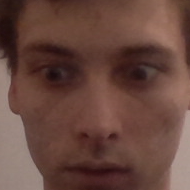

In [35]:
# show one image
img_path = df_both_eyes.iloc[2]['File Path Face Image'] # => face_image_1.png
img = Image.open('../data_collection_phase/data/only_face/' + img_path)
img

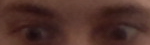

In [36]:
# show one image
img_path = df_both_eyes.iloc[2]['File Path Both Eyes Image'] # => both_eyes_image_1.png
img = Image.open(img_path)
img

### Build CNN

##### Split

In [ ]:
#all_images = df_class['File Path Face Image'].tolist() # => ['face_image_1.png', 'face_image_2.png' ...]
#all_images = [os.path.join('../data_collection_phase/data/only_face', img) for img in all_images] # add to all_images the full path
#images = [np.array(Image.open(path).resize((190, 190))) for path in all_images]
#images_array = np.array(images, dtype=np.float32) / 255.0  # Ensure dtype is float32
#
#all_cells = np.array(df_class['cell'].tolist()).reshape(-1, 1)
#
## Split train/test
#x_train, x_test, y_train, y_test = train_test_split(images_array, all_cells, test_size=0.2, random_state=42)

In [37]:
all_images = df_both_eyes['File Path Both Eyes Image'].tolist() # => ['face_image_1.png', 'face_image_2.png' ...]
images = [np.array(Image.open(path)) for path in all_images]
images_array = np.array(images, dtype=np.float32) / 255.0  # Ensure dtype is float32

all_cells = np.array(df_both_eyes['cell'].tolist()).reshape(-1, 1)

# Split train/test
x_train, x_test, y_train, y_test = train_test_split(images_array, all_cells, test_size=0.1, random_state=42)

In [38]:
# Dataset shapes
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Number of unique classes
num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")

x_train shape: (221, 45, 150, 3)
y_train shape: (221, 1)
x_test shape: (25, 45, 150, 3)
y_test shape: (25, 1)
Number of classes: 25


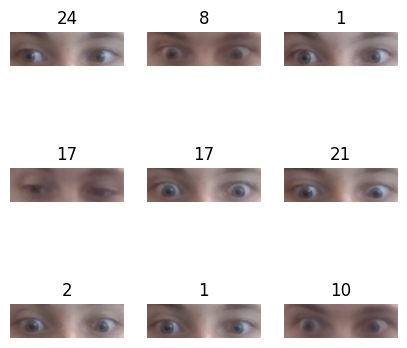

In [39]:
# Define class names for easy reference
class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

# Plot a 3x3 grid of random images from the dataset with their labels
plt.figure(figsize=(5, 5))
for i in range(9):
    index = np.random.randint(0, len(x_train))
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[index])
    plt.title(class_names[y_train[index][0]])
    plt.axis("off")
plt.show()

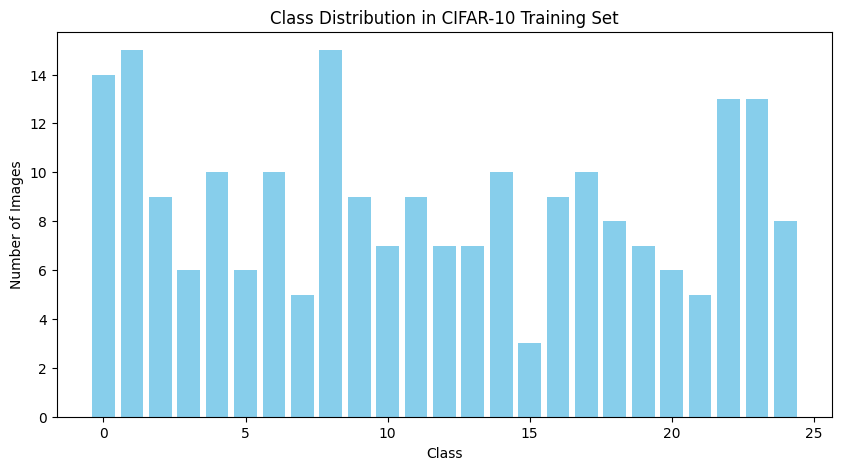

In [40]:
# Count occurrences of each class in the training set
class_counts = np.bincount(y_train.flatten())

# Plot the class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_names, class_counts, color='skyblue')
plt.title("Class Distribution in CIFAR-10 Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [41]:
# Check the minimum and maximum pixel values
print(f"Minimum pixel value: {x_train.min()}")
print(f"Maximum pixel value: {x_train.max()}")

Minimum pixel value: 0.0
Maximum pixel value: 0.9607843160629272


In [42]:
# one hot encode y_train and y_test
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [43]:
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"y_train sample: {y_train[2]}")

y_train shape: (221, 25)
y_test shape: (25, 25)
y_train sample: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


#### Model 1

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ReLU, BatchNormalization, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# Load pre-trained VGG16 (without the fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(45, 150, 3))

# Allow some VGG16 layers to train
#base_model.trainable = True
#for layer in base_model.layers[:-4]:  # Keep last 4 layers trainable
#    layer.trainable = False
base_model.trainable = True

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    BatchNormalization(),
    Dense(num_classes, activation="softmax")
])

# Compile with lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
history = model.fit(x_train, y_train, epochs=50, batch_size=50, verbose=1, validation_data=(x_test, y_test))

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.0483 - loss: 3.6223 - val_accuracy: 0.0400 - val_loss: 3.3936
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.0287 - loss: 3.6010 - val_accuracy: 0.0400 - val_loss: 3.3798
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.0632 - loss: 3.4919 - val_accuracy: 0.0400 - val_loss: 3.3649
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.0519 - loss: 3.4992 - val_accuracy: 0.0400 - val_loss: 3.3573
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.0386 - loss: 3.5288 - val_accuracy: 0.0400 - val_loss: 3.3505
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.0358 - loss: 3.4757 - val_accuracy: 0.0400 - val_loss: 3.3491
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.0607 - loss: 3.5615 - val_accuracy: 0.0400 - val_loss: 3.3387
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.0552 - loss: 3.4750 - val_accuracy: 0.0400 - val_loss: 3.3278
Epoch 9/

#### Model 2

In [18]:
from tensorflow.keras.layers import MaxPool2D

model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=25, activation="softmax"))

from tensorflow import keras
from keras.optimizers import Adam

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()

c:\Users\orlan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │       102,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,362,969 (512.55 MB)

 Trainable params: 134,362,969 (512.55 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(x_train, y_train, epochs=50, batch_size=10, verbose=1, validation_data=(x_test, y_test))

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 148s 6s/step - accuracy: 0.0336 - loss: 3.2195 - val_accuracy: 0.0408 - val_loss: 3.2202
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 117s 6s/step - accuracy: 0.0993 - loss: 3.2088 - val_accuracy: 0.0612 - val_loss: 3.2496
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 117s 6s/step - accuracy: 0.0393 - loss: 3.1809 - val_accuracy: 0.0612 - val_loss: 3.2592
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 117s 6s/step - accuracy: 0.0633 - loss: 3.1857 - val_accuracy: 0.0612 - val_loss: 3.2669
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 115s 6s/step - accuracy: 0.0932 - loss: 3.1605 - val_accuracy: 0.0612 - val_loss: 3.2598
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 113s 6s/step - accuracy: 0.0615 - loss: 3.1804 - val_accuracy: 0.0612 - val_loss: 3.3109
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 116s 6s/step - accuracy: 0.0742 - loss: 3.1509 - val_accuracy: 0.0408 - val_loss: 3.3408
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 112s 6s/step - accuracy: 0.0776 - loss: 3.1669 - val_accuracy: 0.0612 - v

#### Evaluation

In [46]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.0400 - loss: 3.1914
Test accuracy: 0.03999999910593033


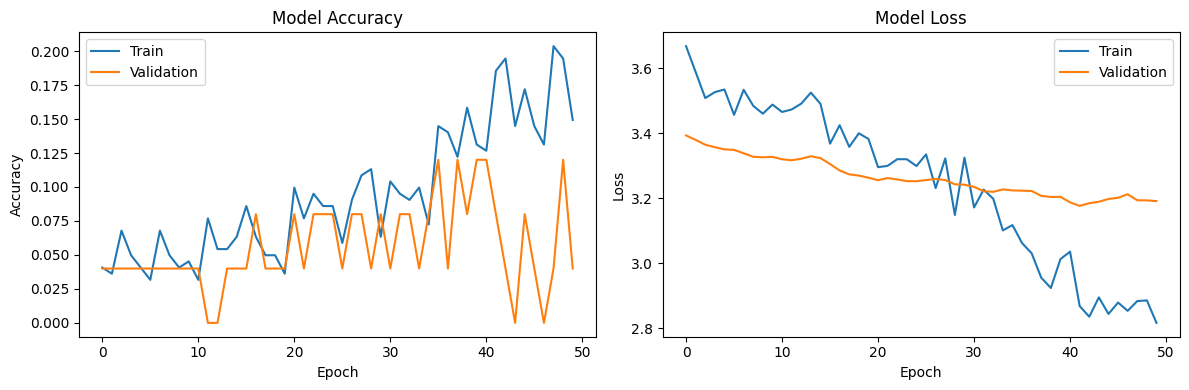

In [47]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


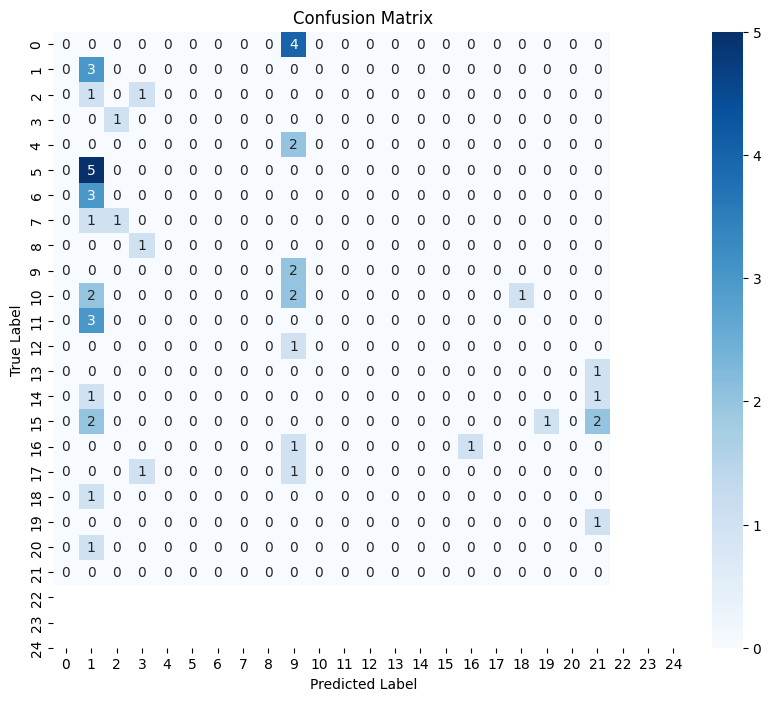

In [24]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# Generate predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [49]:
y_pred_classes = np.argmax(y_pred, axis=1)
# Plot sample images with their predicted and true labels
plt.figure(figsize=(10, 10))
for i in range(16):
    index = np.random.randint(0, len(x_test))
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_test[index])
    true_label = class_names[y_true_classes[index]]
    pred_label = class_names[y_pred_classes[index]]
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=8)
    plt.axis("off")
plt.suptitle("Sample Predictions (Green = Correct, Red = Incorrect)")
plt.show()

NameError: name 'y_pred' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicted class: Bottom Right


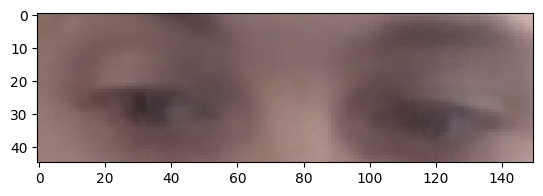

In [60]:
# test with a new image
img_path = 'both_eyes/both_eyes_image_30.png'
img = Image.open(img_path)
img = img.resize((150, 45))
img_array = np.array(img).reshape(1, 45, 150, 3) / 255.0
pred = model.predict(img_array)
pred_class = np.argmax(pred)
print(f"Predicted class: {class_names[pred_class]}")
plt.imshow(img)

In [50]:
# save model
model.save('model.h5')